# Optogenetic Experiment

How can we maximise the activity of neuron 1 in a circuit, when we can only perturn neurons 2, 3, and 4?

We model optogenetic input as an impulse $\mathbf{u} = \delta(t) \mathbf{h} \in \mathbb{R}^3$.
That is the network activity $\mathbf{x}(t)$ evolves according to the equations

$$\begin{align*}
    \displaystyle \frac{d \mathbf{x}}{dt} 
    &= A\mathbf{x} + \delta(t)B\mathbf{h}, \text{ where } \mathbf{x}(0) =
    \mathbf{0}\\
    \mathbf{y} 
    &= C \mathbf{x}.
\end{align*}$$

We choose

$$C = [1, 0, \cdots, 0]^T$$

such that $\mathbf{y}(t)$ is the activity of neuron 1.

We choose $B \in \mathbb{R}^{n \times 3}$ such that

$$B_{ij} = \bigg \{
    \begin{align*}
    1 & \quad \text{if } i=j \in \{2,3,4\}\\
    0 & \quad \text{otherwise.}
    \end{align*}$$

This choice of $B$ makes sure that we only perturb 
neurons 2, 3, and 4 in the model. 

Solving this equation,  we get

\begin{align*}
    \mathbf{y}(t) 
    &= \displaystyle\int_0^t Ce^{A(t - \tau)} B \mathbf{u}(\tau) d\tau\\
    &= \displaystyle\int_0^t Ce^{A(t - \tau)}\delta(\tau) B\mathbf{h} d\tau\\
    &= Ce^{At}B\mathbf{h}.
\end{align*}

## Maximise output energy
The output energy is thus given by

\begin{align*}
\mathcal{E} 
&=  \displaystyle \int_0^\infty \| \mathbf{y}(t) \|^2 dt \\
&=  \displaystyle \int_0^\infty  \mathbf{h}^T Be^{A^Tt}C^T C e^{At}B \mathbf{h}  dt \\
&=  \mathbf{h}^TB^TQB\mathbf{h}
\end{align*}

where the observability Gramian

$$Q = \int_0^\infty e^{A^Tt}C^TCe^{At} dt.$$

The directions that are the most (least) sensitive in the network are the top (bottom)
eigenvectors of $B^TQB$.

### Maximise output magnitude 

We define the magnitude $\mathcal{M}$ of the network output

\begin{align*}
\mathcal{M} 
&= \int_0^\infty  \mathbf{y}  dt \\
&= \int_0^\infty  Ce^{At}B\mathbf{h}  dt \\
&= \big [ Ce^{At}A^{-1}B\mathbf{h} \big ]^\infty_0 \\
&= - CA^{-1}B\mathbf{h}.
\end{align*}

The $\mathbf{h}$ that maximise $\mathcal{M}$ is thus given by $-B^TA^{-T}C^T$.

In [1]:
#use "./init.ml"
open Owl
open Printf
open Noc

In [2]:
(* network connectivity matrix *)
let w = Mat.load_txt "../data/w"
(* number of neurons in the network *)
let n, _ = Mat.shape w
(* A matrix *)
let a = Mat.(w - eye n)
(* time constant *)
let tau = 20E-3
let simulate = Simulate.impulse ~tau ~n ~a

val w : Owl.Mat.mat = ...


val n : int = ...


val a : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val tau : float = ...


val simulate : ?c:Owl.Mat.mat -> input:Owl.Mat.mat -> float -> Owl.Mat.mat =
  ...


In [3]:
(* ------- optogenetic experiment ------ *)
(* if I am allowed to stimulate k cells only,
 * how should I stimulate them to best drive a k+1th cell? *)
let c = Mat.init_2d 1 n (fun _ j -> if j=0 then 1. else 0.)
let n_stim = 10
let b = Mat.init_2d n n_stim (fun i j -> if i=j+165 then 1. else 0.)
let q = Gramians.obsv ~c a
let u, s, _ = Linalg.D.svd Mat.((transpose b) *@ q *@ b)
let x0_opto_mod =
  let x0 = Mat.(transpose (b *@ u)) in
  Mat.(x0 / l2norm ~axis:1 x0)

let opto_best = (* best possible stimulation using non-quadratic analysis *)
  let c = Mat.init_2d n 1 (fun i _ -> if i=0 then 1. else 0.) in
  let ainv = Mat.(neg (inv a)) in
  let x0 = Mat.((transpose c) *@ ainv *@ b *@ transpose b) in
  let x0 = Mat.(x0 / l2norm ~axis:1 x0) in
  simulate ~input:x0 0.3

let opto_obs_best = simulate ~input:Mat.(row x0_opto_mod 0) 0.3 
let opto_obs_random =
  let ts = Mat.col opto_obs_best 0 in
  let x0_opto_random =
    let x0 = Mat.((gaussian 100 n_stim) *@ transpose b) in
    Mat.(x0 / l2norm ~axis:1 x0) in
  let xs_rand = Mat.map_rows (fun x0 ->
      let xs = simulate ~input:x0 0.3 in
      Mat.(col xs 1)
    ) x0_opto_random |> Mat.concatenate ~axis:1 in
  Mat.(concatenate ~axis:1 [| ts; mean ~axis:1 xs_rand; std ~axis:1 xs_rand |])

val c : Owl.Mat.mat = ...


val n_stim : int = ...


val b : Owl.Mat.mat = ...


val q : Owl.Mat.mat = ...


val u : Owl.Linalg.D.mat = ...
val s : Owl.Linalg.D.mat = ...


val x0_opto_mod : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t =
  ...


val opto_best : Owl.Mat.mat = ...


val opto_obs_best : Owl.Mat.mat = ...


val opto_obs_random : Owl.Mat.mat = ...


### Optimal Perturbation

We plot activity evoked by impulse that maximises $\mathcal{E}$ (red) and $\mathcal{M}$ (blue). 
Black trace is the mean response evoked by random impulses (gray shade denotes one standard deviation).

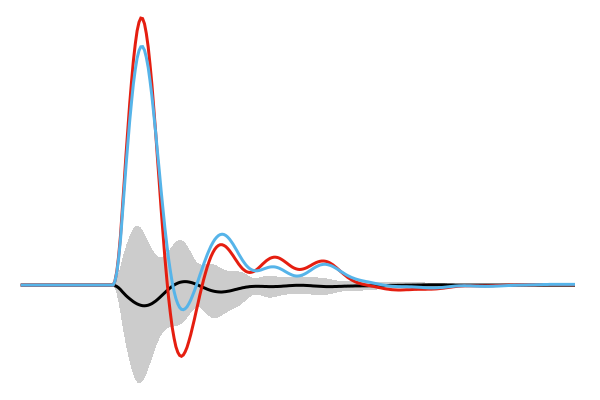

In [4]:
let () =
    let display_id = Jupyter_notebook.display "text/html" "" in
    let open Gp in
    let items = [
        item (A opto_obs_random) ~using:"1:($2+$3):($2-$3)" ~style:"filledcurves fs solid 0.2 noborder fc rgb 'black'";
        item (A opto_obs_random) ~using:"1:2" ~style:"l lc 8 lw 3";
        item (A opto_obs_best) ~using:"1:2" ~style:"l lc 7 lw 3";
        item (A opto_best) ~using:"1:2" ~style:"l lc 3 lw 3"
    ] in
    let figure (module P: Plot) = 
        P.plots items
        [ barebone ; ] in
    Juplot.draw ~display_id figure